![](https://images.pexels.com/photos/1077327/pexels-photo-1077327.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Magnetometer Calibration

To calibrate a magnetometer, you need to get readings from all directions in 3D space. Ideally, when you plot the readings out, you should get a perfect sphere centered at (0,0,0). However, due to misalignments, offset, etc ... you end up with ellipsoids centered at some biased location.

Here we are going to try and get enough readings to estimate these errors and properly calibrate the sensor. We will load in a pre-recorded data set, where the sensor was tumbled around and calibrate it.

## Errors

![](soft-and-hard.png)

- **Soft iron errors:** caused by distortion of the Earth's magnetic field due to materials in the environment. Think of it like electricity - the magnetic field is looking for the easiest path to get to where it is going. Since magnetic fields can flow more easily through ferromagnetic materials than air, more of the field will flow through the ferromagnetic material than you would expect if it were just air. This distortion effect causes the magnetic field lines to be bent sometimes quite a bit. Note that unlike hard iron interference which is the result of materials which actually have a magnetic field of their own, soft iron interference is caused by non-magnetic materials distorting the Earth's magnetic field. This type of interference has a squishing effect on the magnetic data circle turning it into more of an ellipsoid shape. The distortion in this case depends on the direction that the compass is facing. Because of this, the distortion cannot be calibrated out with a simple offset
- **Hard iron errors:** caused by static magnetic fields associated with the enviornment. For example, this could include any minor (or major) magnetism in the metal chassis or frame of a vehicle, any actual magnets such as speakers, etc... This interference pattern is unique to the environment but is constant. If you have your compass in an enclosure that is held together with metal screws, these relatively small amounts of ferromagnetic material can cause issues. If we consider the magnetic data circle, hard iron interference has the effect of shifting the entire circle away from the origin by some amount. The amount is dependent on any number of different factors and can be very large. 

## Calibrations

In all cases, you need to gather data from the magnitometers across
all axes. The best way is to tumble it and grave a couple thousand
data points.


## References

- Ozyagcilar, T. ["Calibrating an eCompass in the Presence of Hard and Soft-iron Interference."](AN4246.pdf) Freescale Semiconductor Ltd. 1992, pp. 1-17.
- [Teslabs: Magnetometer Calibration](https://teslabs.com/articles/magnetometer-calibration/)
- [ThePoorEngineer: Calibrating the Magnetometer](https://www.thepoorengineer.com/en/calibrating-the-magnetometer/)
- Mathworks: [magcal](https://www.mathworks.com/help/fusion/ref/magcal.html#mw_34252c54-1f78-46b9-8c30-1a2b7351b0ce)

In [42]:
import numpy as np # matrix manipulations
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

from scipy import linalg
import sys

from the_collector import BagIt
from the_collector import Pickle, Json

from matplotlib import pyplot as plt

from math import radians as deg2rad
from math import degrees as rad2deg

from slurm import storage
import os

In [2]:
def plotMagnetometer(data, title=None):
    x = [v[0] for v in data]
    rx = (max(x)-min(x))/2
    cx = min(x)+rx
    
    y = [v[1] for v in data]
    ry = (max(y)-min(y))/2
    cy = min(y)+ry
    
    z = [v[2] for v in data]
    rz = (max(z)-min(z))/2
    cz = min(z)+rz
    
    alpha = 0.5
    u = np.linspace(0, 2 * np.pi, 100)
    
    plt.plot(rx*np.cos(u)+cx, ry*np.sin(u)+cy,'-r',label='xy')
    plt.plot(x,y,'.r',alpha=alpha)
    
    plt.plot(rx*np.cos(u)+cx, rz*np.sin(u)+cz,'-g',label='xz')
    plt.plot(x,z,'.g',alpha=alpha)
    
    plt.plot(rz*np.cos(u)+cz, ry*np.sin(u)+cy,'-b',label='zy')
    plt.plot(z,y, '.b',alpha=alpha)
    
    plt.title(f"CM:({cx:.1f}, {cy:.1f}, {cz:.1f}) uT  R:({rx:.1f}, {ry:.1f}, {rz:.1f}) uT")
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.grid(True);
    plt.axis('equal')
    plt.legend();

In [3]:
def get_np(bag, key):
    d = []
    dt = []
    last = None
    for v,ts in bag[key]:
        d.append(v)
        if last is None:
            last = ts
        else:
            dt.append(ts - last)
            last=ts
    return np.array(d), np.array(dt)


def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

In [4]:
# let's load in some data and have a look at what we have
bag = BagIt(Pickle)
fname = "~/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag"
fname = os.path.expanduser(fname)

data = bag.read(fname)
bag_info(data)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag
Bag keys:
--------------------------------------------------
       accel: 3193   
         mag: 3193   
        gyro: 3193   


In [5]:
rawmag, dt = get_np(data, "mag")

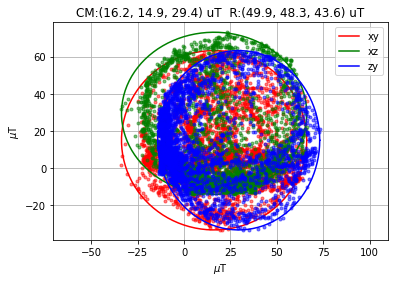

In [22]:
plotMagnetometer(rawmag)

# Calibrate using Elliptical Fit

In [7]:
def calibrate(s, F=1):
    ''' Performs calibration of magnetometer data by performing an 
    elliptical fit of the data. 
    
    F: expected field strength, default is 1
    Returns: an A and b matrix, such that, actual_mag = A*noisy_mag + b
    '''
    s = s.T
    
    # D (samples)
    D = np.array([
        s[0]**2., s[1]**2., s[2]**2.,
        2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
        2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

    # S, S_11, S_12, S_21, S_22 (eq. 11)
    S = np.dot(D, D.T)
    S_11 = S[:6,:6]
    S_12 = S[:6,6:]
    S_21 = S[6:,:6]
    S_22 = S[6:,6:]

    # C (Eq. 8, k=4)
    C = np.array([[-1,  1,  1,  0,  0,  0],
                  [ 1, -1,  1,  0,  0,  0],
                  [ 1,  1, -1,  0,  0,  0],
                  [ 0,  0,  0, -4,  0,  0],
                  [ 0,  0,  0,  0, -4,  0],
                  [ 0,  0,  0,  0,  0, -4]])

    # v_1 (eq. 15, solution)
    E = np.dot(
        linalg.inv(C),
        S_11 - np.dot(S_12, np.dot(linalg.inv(S_22), S_21)))

    E_w, E_v = np.linalg.eig(E)

    v_1 = E_v[:, np.argmax(E_w)]
    if v_1[0] < 0: v_1 = -v_1

    # v_2 (eq. 13, solution)
    v_2 = np.dot(np.dot(-np.linalg.inv(S_22), S_21), v_1)

    # quadric-form parameters
    M = np.array([[v_1[0], v_1[3], v_1[4]],
                  [v_1[3], v_1[1], v_1[5]],
                  [v_1[4], v_1[5], v_1[2]]])
    n = np.array([[v_2[0]],
                  [v_2[1]],
                  [v_2[2]]])
    d = v_2[3]

    #-------------------------------------
    # calibration parameters
    # note: some implementations of sqrtm return complex type, taking real
    M_1 = linalg.inv(M)
    b = -np.dot(M_1, n).T[0]  # make numpy array [bx,by,bz]

    A = F / np.sqrt(np.abs(np.dot(n.T, np.dot(M_1, n)) - d)) 
    A = A*np.real(linalg.sqrtm(M))

    return A, b

In [8]:
# https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm
# uT
uT = 50.8862

In [9]:
A, b = calibrate(rawmag, uT)
print(f">> A:\n{A}")
print(f">> b: {b}")

>> A:
[[ 1.136  0.014 -0.01 ]
 [ 0.014  1.144 -0.006]
 [-0.01  -0.006  1.234]]
>> b: [20.283 16.526 29.552]


In [10]:
corrected=(np.dot(A,(rawmag-b).T)).T

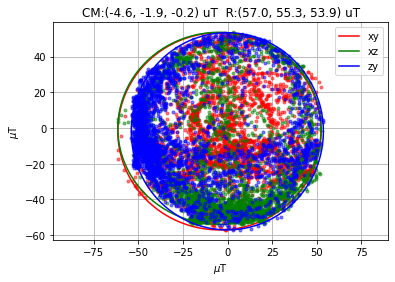

In [11]:
plotMagnetometer(corrected)

# Matlab `magcal`

`A, b, expfs = magcal(D, [uT])`

$$
C = (D-b)A
$$

where $C$ is the corrected reading, $D$ is the raw magnetometer reading, $b$ is the hard iron effect (bias), and $A$ is the soft iron effect (shape). 

- matlab: [magcal](https://www.mathworks.com/help/nav/ref/magcal.html)

In [12]:
def magcal(Bp, uT=None):
    """
    Modelled after the matlab function: magcal(D) -> A, b, expmfs
    inputs:
      Bp: data points
      uT: expected field strength for longitude/altitude. If None
          is given, then automatically calculated and used
    returns:
      A: soft-iron 3x3 matrix of scaling
      b: hard-iron offsets
      expmfs: expected field strength"""
    Y = np.array([v[0]**2+v[1]**2+v[2]**2 for v in Bp])
    X = np.hstack((Bp,np.ones((Bp.shape[0],1))))
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    b=0.5*beta[:3]
    
    # expected mag field strength
    expmfs=np.sqrt(beta[3]+b[0]**2+b[1]**2+b[2]**2)
    
    if uT is None:
        uT = expmfs
    
    x = [v[0] for v in Bp]
    rx = (max(x)-min(x))/2

    y = [v[1] for v in Bp]
    ry = (max(y)-min(y))/2

    z = [v[2] for v in Bp]
    rz = (max(z)-min(z))/2
    
    A = np.diag([uT/rx,uT/ry,uT/rz])
    return A,b,expmfs

>> soft-iron correction:
[[0.864 0.    0.   ]
 [0.    0.893 0.   ]
 [0.    0.    0.988]]
>> hard-iron offset: [20.553 16.331 30.067]uT   expmfs: 43.1uT


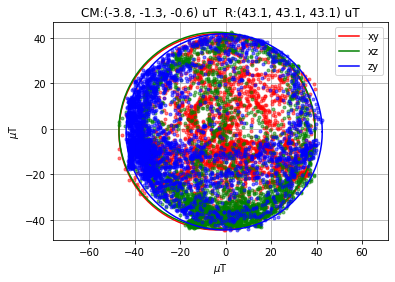

In [13]:
# calibrated w/o expected field strength
A,vv,bb = magcal(rawmag)
print(f">> soft-iron correction:\n{A}")
print(f">> hard-iron offset: {vv}uT   expmfs: {bb:.1f}uT")
plotMagnetometer((rawmag-vv).dot(A))

>> soft-iron correction:
[[1.02  0.    0.   ]
 [0.    1.054 0.   ]
 [0.    0.    1.166]]
>> hard-iron offset: [20.553 16.331 30.067]uT   expmfs: 43.1uT


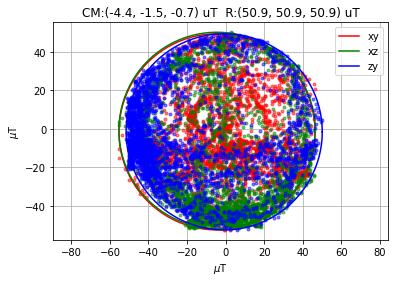

In [14]:
# calibrated with expected field strength - it only changes
# the radius of the circles
A,vv,bb = magcal(rawmag,uT)
print(f">> soft-iron correction:\n{A}")
print(f">> hard-iron offset: {vv}uT   expmfs: {bb:.1f}uT")
plotMagnetometer((rawmag-vv).dot(A))

# Another Way

In [15]:
def other(Bpp):
    """
    D = [X2, Y2, Z2, 2XY,2XZ, 2YZ, 2X, 2Y, 2Z]
    v = [ a, b, c, d, e, f, g, h, i ]
    1 [Nx1] 
    v[9x1] = inv(DT D)[9x9] (DT 1)[9x1]

    A = [ 
        v(1) v(4) v(5) v(7); 
        v(4) v(2) v(6) v(8); 
        v(5) v(6) v(3) v(9); 
        v(7) v(8) v(9) -1 ]; 
    ofs=-A(1:3,1:3)\[v(7);v(8);v(9)]; % offset is center of ellipsoid
    Tmtx=eye(4); 
    Tmtx(4,1:3)=ofs'; 
    AT=Tmtx*A*Tmtx'; % ellipsoid translated to (0,0,0)
    [rotM ev]=eig(AT(1:3,1:3)/-AT(4,4)); % eigenvectors (rotation) and eigenvalues (gain) 
    gain=sqrt(1./diag(ev)); % gain is radius of the ellipsoid
    """
    x = Bpp[:,0]
    y = Bpp[:,1]
    z = Bpp[:,2]
    sz = len(Bpp)
    D = np.array([x*x,y*y,z*z,2*x*y,2*x*z,2*y*z,2*x,2*y,2*z]).T
    v = np.linalg.inv(D.T @ D) @ (D.T @ np.ones(sz))
    print(v)
    A = np.array([
        [v[0], v[3], v[4], v[6]],
        [v[3], v[1], v[5], v[7]],
        [v[4], v[5], v[2], v[8]],
        [v[6], v[7], v[8],   -1]
    ])

    ofs=-np.linalg.inv(A[:3,:3]) @ np.array([v[6], v[7], v[8]]).T
    Tmtx = np.eye(4)
    Tmtx[3,:3] = ofs
    AT = Tmtx @ A @ Tmtx.T
    ev, rotM = np.linalg.eig(AT[:3,:3]/-AT[3,3])
    gain = np.sqrt(1/ev)  # added abs, negative sqrt values

    print(f"gain: {gain}")
    print(f"offsets: {ofs}")
    print(f"rot mat: \n {rotM}")
    return gain, ofs, rotM

In [39]:
gain, ofs, rotM = other(rawmag)

mc = rawmag - ofs

xyzc = uT * (mc @ rotM) @ np.diag(1/gain)

[ 0.001  0.001  0.001 -0.    -0.    -0.    -0.005 -0.005 -0.022]
gain: [59.084 42.531 39.118]
offsets: [18.071 13.715 26.445]
rot mat: 
 [[ 0.736  0.512 -0.442]
 [ 0.535 -0.841 -0.084]
 [ 0.415  0.175  0.893]]


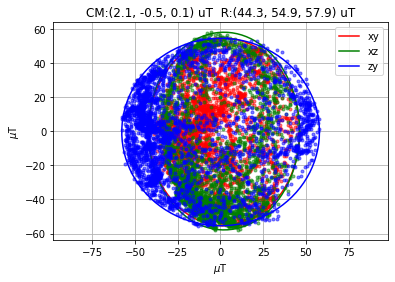

In [40]:
# cm(2.1,-0.5,0.1) r(44.3,54.9,57.9)
plotMagnetometer(xyzc)